In [2]:
# セルの最初に（他のインポートより前に）
import os
os.environ['LIBGL_DRIVERS_PATH'] = '/usr/lib/x86_64-linux-gnu/dri'
os.environ['LIBGL_ALWAYS_SOFTWARE'] = '1'

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from neuromaps import stats
import glob
from util import plot
from util.atlas import Atlas
import matplotlib.pyplot as plt
from constants import SUBS

import seaborn as sns
from pathlib import Path
from neuromaps import stats


%matplotlib inline
plt.rcParams['figure.dpi'] = 60

def load_results(h5_path: str) -> dict:
    """HDF5ファイルから結果を読み込む"""
    results = {}
    with h5py.File(h5_path, "r") as f:
        for key in f.keys():
            results[key] = f[key][...]
    return results

def extract_scores(results: dict, narratives: list) -> dict:
    """各train->testペアのスコアを抽出"""
    scores_dict = {}
    for train_narr in narratives:
        for test_narr in narratives:
            # if train_narr == test_narr:
            #     continue
            key = f"{train_narr}->{test_narr}_scores"
            if key in results:
                scores_dict[(train_narr, test_narr)] = results[key]
    return scores_dict

def compute_voxel_scores(scores: np.ndarray) -> np.ndarray:
    """ボクセルごとのスコアを計算（特徴量グループがある場合は合算）"""
    if scores.ndim > 1:
        return scores.sum(axis=0)
    return scores

def compute_mean_scores(scores_dict: dict) -> dict:
    """各ペアの平均相関を計算"""
    mean_scores = {}
    for (train_narr, test_narr), scores in scores_dict.items():
        voxel_scores = compute_voxel_scores(scores)
        mean_scores[(train_narr, test_narr)] = np.mean(voxel_scores)
    return mean_scores

/home/s-kawashima/miniconda3/envs/zaida_tutorial/lib/python3.12/site-packages/neuromaps/datasets/utils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
whisper_tiny_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/whisper-tiny_layer-3/sub-average.h5"
sa_whisper_tiny_path = "/home/s-kawashima/research/output/results/encoding_average_sentence-audio/sub-average/whisper-tiny_layer-3/sub-average.h5"
sbert_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/all-MiniLM-L6-v2_cumulative_layer-6/sub-average.h5"
sbert_fixed_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/all-MiniLM-L6-v2_cumulative_sentence_embedding/sub-average.h5"
multimodal_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/combined_whisper-whisper-tiny_layer-3_sbert-all-MiniLM-L6-v2_layer-6/sub-average.h5"
whisper_tiny_results = load_results(whisper_tiny_path)
sa_whisper_tiny_results = load_results(sa_whisper_tiny_path)
sbert_results = load_results(sbert_path)
sbert_fixed_results = load_results(sbert_fixed_path)
multimodal_results = load_results(multimodal_path)

print("読み込んだキー:")
for key in sorted(whisper_tiny_results.keys()):
    print(f"  {key}: shape={whisper_tiny_results[key].shape}")

print("読み込んだキー:")
for key in sorted(sa_whisper_tiny_results.keys()):
    print(f"  {key}: shape={sa_whisper_tiny_results[key].shape}")

print("読み込んだキー:")
for key in sorted(sbert_fixed_results.keys()):
    print(f"  {key}: shape={sbert_fixed_results[key].shape}")
    
# 物語のリスト
NARRATIVES = ["black", "forgot", "piemanpni", "bronx"]

読み込んだキー:
  black->black_actual: shape=(534, 1000)
  black->black_preds: shape=(3, 534, 1000)
  black->black_scores: shape=(3, 1000)
  black->bronx_actual: shape=(358, 1000)
  black->bronx_preds: shape=(3, 358, 1000)
  black->bronx_scores: shape=(3, 1000)
  black->forgot_actual: shape=(558, 1000)
  black->forgot_preds: shape=(3, 558, 1000)
  black->forgot_scores: shape=(3, 1000)
  black->piemanpni_actual: shape=(267, 1000)
  black->piemanpni_preds: shape=(3, 267, 1000)
  black->piemanpni_scores: shape=(3, 1000)
  bronx->black_actual: shape=(534, 1000)
  bronx->black_preds: shape=(3, 534, 1000)
  bronx->black_scores: shape=(3, 1000)
  bronx->bronx_actual: shape=(358, 1000)
  bronx->bronx_preds: shape=(3, 358, 1000)
  bronx->bronx_scores: shape=(3, 1000)
  bronx->forgot_actual: shape=(558, 1000)
  bronx->forgot_preds: shape=(3, 558, 1000)
  bronx->forgot_scores: shape=(3, 1000)
  bronx->piemanpni_actual: shape=(267, 1000)
  bronx->piemanpni_preds: shape=(3, 267, 1000)
  bronx->piemanpni_s

In [3]:
# half1_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average_half1/whisper-tiny_layer-3/sub-average_half1.h5"

# half2_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average_half2/whisper-tiny_layer-3/sub-average_half2.h5"
# # データ読み込み
# half1_results = load_results(half1_path)
# half2_results = load_results(half2_path)

# print("読み込んだキー:")
# for key in sorted(half1_results.keys()):
#     print(f"  {key}: shape={half1_results[key].shape}")
# # 物語のリスト
# NARRATIVES = ["black", "forgot", "piemanpni", "bronx"]

In [4]:
atlas = Atlas.schaefer(parcels=1000, networks=7, kong=False)

In [6]:
TARGET_NETWORKS = ['SomMot', 'DorsAttn', 'SalVentAttn', 'Default']
parcel_labels = atlas.labels

def get_network_mask(labels, target_networks):
    mask = np.zeros(len(labels), dtype=bool)
    for i, label in enumerate(labels):
        for network in target_networks:
            if f'_{network}_' in label:
                mask[i] = True
                break
    return mask

network_mask = get_network_mask(parcel_labels, TARGET_NETWORKS)

In [ ]:
# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 1  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Encoding"

values = whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan

fig, ax = plt.subplots(figsize=(6, 5))
plot.surface_plot(atlas.parc_to_vox(values), cmap='hot', vmin=0.05, vmax=0.2, 
                  title=f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fig=fig, ax=ax, cbar=False)
# fig.savefig(f'./surface_plot/sa_whisper_tiny_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}.png', dpi=150, bbox_inches='tight')
plt.show()

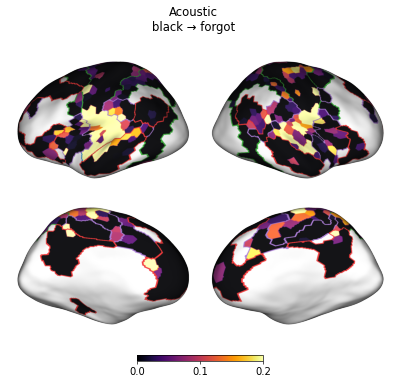

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Acoustic"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = sa_whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels

for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# 凡例追加
# legend_patches = [mpatches.Patch(color=info['color'], label=name) 
#                   for name, info in TARGET_NETWORKS_INFO.items()]
# fig.legend(handles=legend_patches, loc='lower right', fontsize=10)

fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/sa_whisper_tiny_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Decoding"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels

for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# 凡例追加
# legend_patches = [mpatches.Patch(color=info['color'], label=name) 
#                   for name, info in TARGET_NETWORKS_INFO.items()]
# fig.legend(handles=legend_patches, loc='lower right', fontsize=10)

fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/whisper_tiny_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'whisper_tiny_results' is not defined

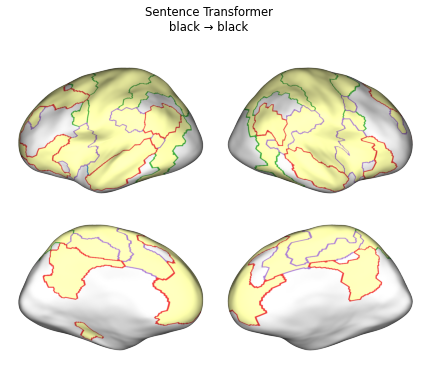

In [27]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# hotカラーマップから白を除外（0~0.85の範囲を使用）
hot_cmap = plt.cm.hot
hot_no_white = LinearSegmentedColormap.from_list(
    'hot_no_white', 
    hot_cmap(np.linspace(0, 0.85, 256))
)

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "black"
FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = sbert_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー（修正したカラーマップを使用）
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/sbert_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

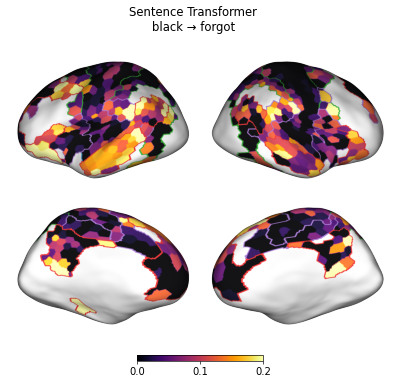

In [56]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# hotカラーマップから白を除外（0~0.85の範囲を使用）
hot_cmap = plt.cm.hot
hot_no_white = LinearSegmentedColormap.from_list(
    'hot_no_white', 
    hot_cmap(np.linspace(0, 0.85, 256))
)

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = sbert_fa_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー（修正したカラーマップを使用）
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/sbert_fa_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

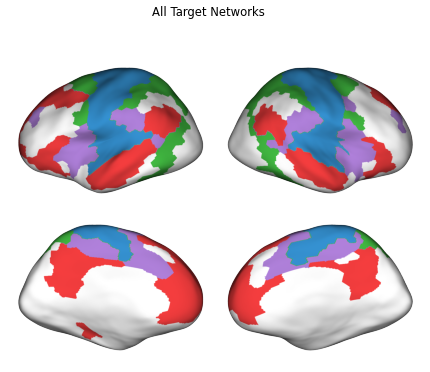

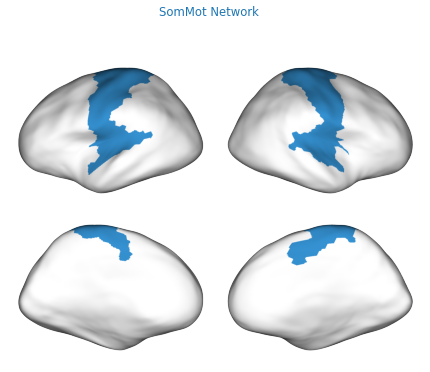

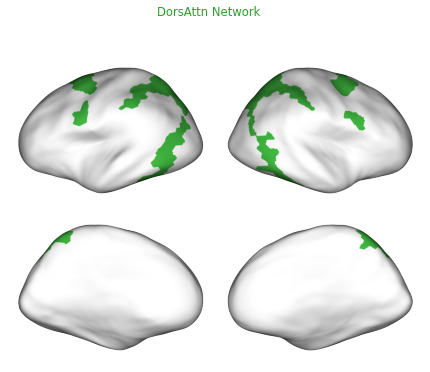

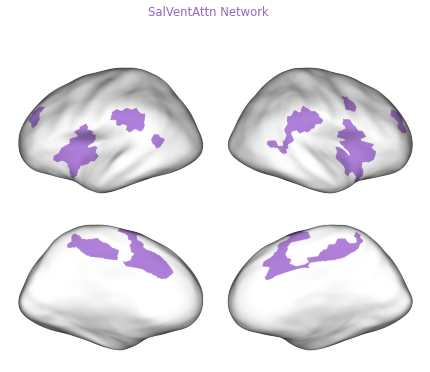

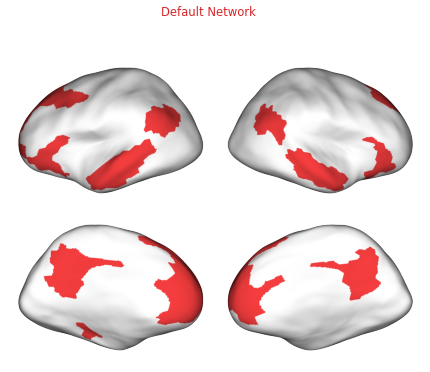

In [26]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

# ネットワーク定義と色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4', 'id': 1},      # 青
    'DorsAttn': {'color': '#2ca02c', 'id': 2},    # 緑
    'SalVentAttn': {'color': '#9467bd', 'id': 3}, # 紫
    'Default': {'color': '#d62728', 'id': 4}      # 赤
}

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

parcel_labels = atlas.labels

# === 全ネットワークまとめて表示 ===
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

network_ids = np.zeros(len(parcel_labels))
for net_name, info in TARGET_NETWORKS_INFO.items():
    for i, label in enumerate(parcel_labels):
        if f'_{net_name}_' in label:
            network_ids[i] = info['id']

network_vertex = atlas.parc_to_vox(network_ids)
colors = ['#dddddd', '#1f77b4', '#2ca02c', '#9467bd', '#d62728']
cmap = ListedColormap(colors)

p.add_layer(network_vertex, cmap=cmap, cbar=False, color_range=[0, 4])
fig = p.build()

# legend_patches = [mpatches.Patch(color=info['color'], label=name) 
#                   for name, info in TARGET_NETWORKS_INFO.items()]
# fig.legend(handles=legend_patches, loc='lower right', fontsize=12)
fig.suptitle('All Target Networks', fontsize=14)
fig.savefig('./surface_plot/target_networks.png', dpi=300, bbox_inches='tight')
plt.show()

# === 各ネットワーク個別に表示 ===
for net_name, info in TARGET_NETWORKS_INFO.items():
    p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)
    
    # そのネットワークだけのマスク
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    # カラーマップ（0=灰色、1=ネットワーク色）
    cmap = ListedColormap(['#dddddd', info['color']])
    
    p.add_layer(network_vertex, cmap=cmap, cbar=False, color_range=[0, 1])
    fig = p.build()
    fig.suptitle(f'{net_name} Network', fontsize=14, color=info['color'])
    fig.savefig(f'./surface_plot/{net_name}_network.png', dpi=300, bbox_inches='tight')
    plt.show()

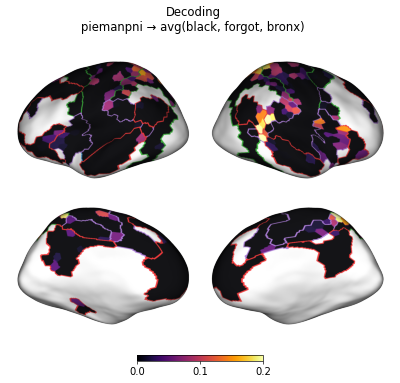

In [62]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "piemanpni"
TEST_STORIES = ["black", "forgot", "bronx"]  # 3つのテストストーリー
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Decoding"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = sa_whisper_tiny_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

fig.savefig(f'./surface_plot/sa_whisper_tiny_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

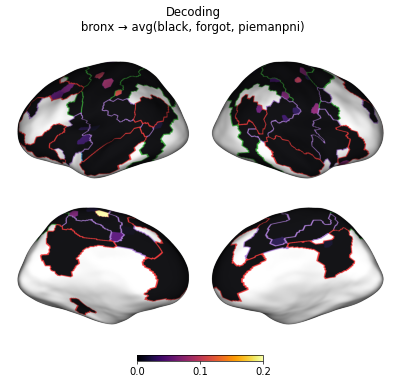

In [67]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "bronx"
TEST_STORIES = ["black", "forgot", "piemanpni"]  # 3つのテストストーリー
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Decoding"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = whisper_tiny_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

fig.savefig(f'./surface_plot/whisper_tiny_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

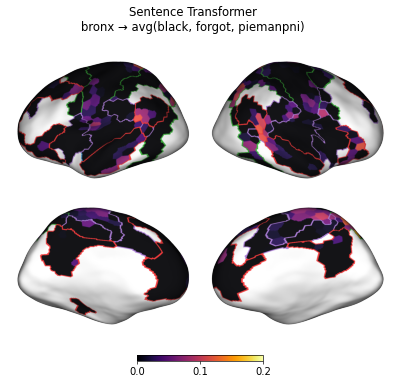

In [66]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "bronx"
TEST_STORIES = ["black", "forgot", "piemanpni"]  # 3つのテストストーリー
FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = sbert_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

fig.savefig(f'./surface_plot/sbert_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

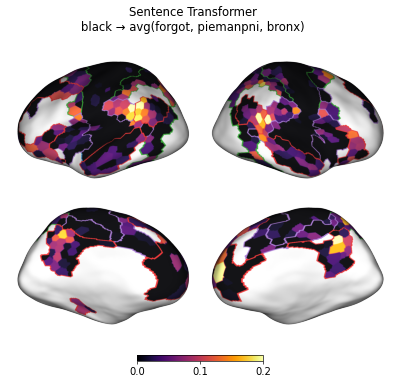

In [59]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]  # 3つのテストストーリー
FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = sbert_fixed_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

fig.savefig(f'./surface_plot/sbert_fixed_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# atarashiiyatsu

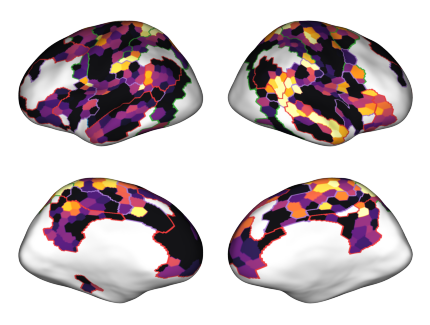

In [21]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np # NumPyのインポートを追加

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"] # 3つのテストストーリー
# FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding # <- 削除
FEATURE_NAME = "Whisper-tiny_Score" # <- 特徴量名を更新

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = np.sum(whisper_tiny_results[f'{TRAIN_STORY}->{TRAIN_STORY}_scores'], axis=0).copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
# Color rangeは合計値に合わせて調整が必要かもしれません
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

# ファイル名を更新
fig.savefig(f'./surface_plot/whisper-tiny_sum_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show() # 環境に合わせて必要であればコメントを外してください

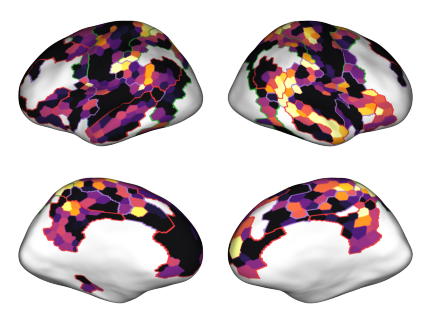

In [22]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np # NumPyのインポートを追加

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"] # 3つのテストストーリー
# FEATURE_IDX = 0  # 0=Acoustic, 1=Encoding, 2=Decoding # <- 削除
FEATURE_NAME = "Multimodal Score" # <- 特徴量名を更新

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = np.sum(multimodal_results[f'{TRAIN_STORY}->{test_story}_scores'], axis=0).copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan

vertex_data = atlas.parc_to_vox(values)

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
# Color rangeは合計値に合わせて調整が必要かもしれません
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    # parcel単位でネットワークマスクを作成
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    # vertex単位に変換
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# タイトルを更新（平均であることを明示）
# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → avg({", ".join(TEST_STORIES)})', fontsize=14)

# ファイル名を更新
fig.savefig(f'./surface_plot/multimodal_sum_{TRAIN_STORY}_to_avg_{"_".join(TEST_STORIES)}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show() # 環境に合わせて必要であればコメントを外してください

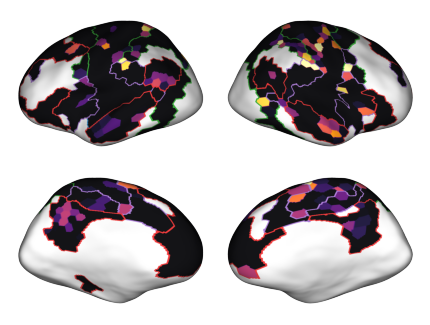

In [26]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "black"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "sbert"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = whisper_tiny_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー（修正したカラーマップを使用）
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/whisper-tiny_{TRAIN_STORY}_to_{TEST_STORY}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

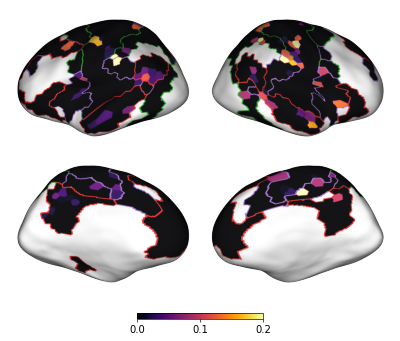

In [40]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "bronx"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence_Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = multimodal_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー（修正したカラーマップを使用）
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
fig.savefig(f'./surface_plot/multimodal_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
            dpi=300, bbox_inches='tight')
plt.show()

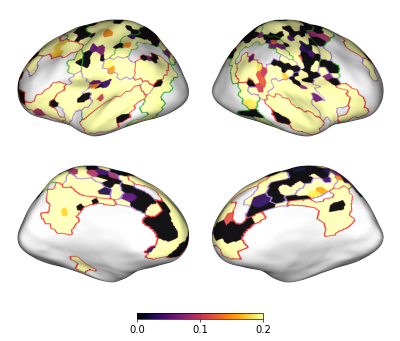

In [31]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# hotカラーマップから白を除外（0~0.85の範囲を使用）
hot_cmap = plt.cm.hot
hot_no_white = LinearSegmentedColormap.from_list(
    'hot_no_white', 
    hot_cmap(np.linspace(0, 0.85, 256))
)

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "black"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Sentence Transformer"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#1f77b4'},      # 青
    'DorsAttn': {'color': '#2ca02c'},    # 緑
    'SalVentAttn': {'color': '#9467bd'}, # 紫
    'Default': {'color': '#d62728'}      # 赤
}

# データ準備
values = multimodal_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー（修正したカラーマップを使用）
p.add_layer(vertex_data, cmap='inferno', cbar=True, color_range=[0.05, 0.2])

# 各ネットワークのアウトラインを追加
parcel_labels = atlas.labels
for net_name, info in TARGET_NETWORKS_INFO.items():
    network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
    p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
                as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
# fig.savefig(f'./surface_plot/sbert_fa_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_outlined.png', 
#             dpi=300, bbox_inches='tight')
plt.show()